In [1]:
# Copyright (c) 2024, InfinityQ Technology Inc.

# Installing Python dependencies
!pip install -r "requirements.txt" --upgrade

import numpy as np
from titanq import Model, Vtype, Target, S3Storage
import utils
from collections import defaultdict
import logging

import sys
sys.path.append("quantum-protein-folding/src")

from protein_folding.interactions.miyazawa_jernigan_interaction import MiyazawaJerniganInteraction
from protein_folding.peptide.peptide import Peptide
from protein_folding.protein_folding_problem import (
    ProteinFoldingProblem,
)
from protein_folding.penalty_parameters import PenaltyParameters
from protein_folding.protein_folding_result import ProteinFoldingResult
from qiskit.opflow import PauliSumOp

### Setting Credentials for TitanQ
The user should configure their TitanQ API key here. For very large problems, the user must also configure an AWS Access key, AWS Secret Access key and AWS Bucket Name.

In [ ]:
logging.getLogger('botocore').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)

# Enter your API key here
# Obtain your API key by contacting --> support@infinityq.tech
# Example: TITANQ_DEV_API_KEY = "00000000-0000-0000-0000-000000000000"
TITANQ_DEV_API_KEY = None

# Specify AWS keys and bucket name for solving very large problems
# AWS_ACCESS_KEY = "Access Key"
# AWS_SECRET_ACCESS_KEY = "Secret Access Key"
# AWS_BUCKET_NAME = "Bucket Name"

### Protein Problem Specification

In [3]:
main_chain = "APRLRFY"
side_chains = [""] * 7

#Interaction between Amino Acids
mj_interaction = MiyazawaJerniganInteraction()
penalty_back = 10
penalty_chiral = 10
penalty_1 = 10

penalty_terms = PenaltyParameters(penalty_chiral, penalty_back, penalty_1)
peptide = Peptide(main_chain, side_chains)

protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
qubit_op_temp = protein_folding_problem.qubit_op()

paulis = qubit_op_temp.primitive.paulis.to_labels()
coefs = qubit_op_temp.primitive.coeffs

# Convert complex coefficients to integer biases
integer_coeffs = np.array([int(coeff.real) for coeff in coefs])

# Create a new PauliSumOp with integer coefficients
qubit_op = PauliSumOp.from_list(list(zip(paulis,integer_coeffs)))

### Transformation from TFIM (Transverse Field Ising Model) to QUBO (Quadratic Unconstrained Binary Optimization) 

In [4]:
#Conversion from TFIM to higher-order bipolar model
coefficients = utils.extract_pauli_strings_and_coeffs(qubit_op)

#Dictionary where the keys are terms from the TFIM and values are the corresponding numerical coefficients
formulation = {}

for element in coefficients:
    val = element[1]
    key = utils.from_pauli_to_bipolar(element[0])
    formulation[key] = int(val)

#Conversion from bipolar to binary variables
original_num_variables = 9
z_vars = [f'z{i}' for i in range(original_num_variables)]
formulation_x = utils.transform_polynomial(formulation,list(z_vars),label="x")
shift = formulation_x[()]
del formulation_x[()]

#Higher-order reduction to quadratic
qubo_dict = utils.reduce_min(formulation_x,num_vars=original_num_variables,variable_label="x",starting_index=0)

### Construction of Weights Matrix and Bias Vector for TitanQ Input

In [5]:
linear_terms = defaultdict(lambda : 0,qubo_dict[0])
quadratic_terms = defaultdict(lambda : 0,qubo_dict[1])
num_variables = qubo_dict[2]

all_variables = [f'x{i}' for i in range(num_variables)]

bias = np.zeros(num_variables,dtype=np.float32)
weights = np.zeros((num_variables,num_variables),dtype=np.float32)

for i in range(num_variables):
    for j in range(i,num_variables):
        if i == j:
            bias[i] = linear_terms[all_variables[i]]
        else:
            if (all_variables[i],all_variables[j]) in quadratic_terms:
                weights[i,j] = quadratic_terms[(all_variables[i],all_variables[j])]
                weights[j,i] = quadratic_terms[(all_variables[i],all_variables[j])]
            elif (all_variables[j],all_variables[i]) in quadratic_terms:
                weights[i,j] = quadratic_terms[(all_variables[j],all_variables[i])]
                weights[j,i] = quadratic_terms[(all_variables[j],all_variables[i])]

### TitanQ Model Construction + Solve

In [6]:
############
# TitanQ SDK
############
# Initialize the model
model = Model(
    api_key=TITANQ_DEV_API_KEY,
    # Insert storage_client parameter and specify corresponding AWS keys and bucket name for solving very large problems
    # storage_client=S3Storage(
    #     access_key=AWS_ACCESS_KEY,
    #     secret_key=AWS_SECRET_ACCESS_KEY,
    #     bucket_name=AWS_BUCKET_NAME
    # )
) 

# Construct the problem
model.add_variable_vector('x', len(weights), Vtype.BINARY)
model.set_objective_matrices(weights, bias, Target.MINIMIZE)

# Set hyperparameters and call the solver
num_chains = 2
num_engines = 256
T_min = 1e3
T_max = 1e16
beta = (1.0/np.linspace(T_min, T_max, num_chains)).tolist()

timeout_in_seconds = 5
coupling_mult = 0.5

response = model.optimize(
    beta=beta,
    timeout_in_secs=timeout_in_seconds,
    num_engines=num_engines,
    num_chains=num_chains,
    coupling_mult=coupling_mult
)

#Retrieving minimum energy and corresponding state
ising_energy, result_vector = min(response.result_items(),key= lambda x : x[0])

print("-" * 15, "+", "-" * 26, sep="")
print("TitanQ Ising energy   | Result vector")
print("-" * 15, "+", "-" * 26, sep="")
print(f"{ising_energy + shift} | {result_vector.tolist()}")

---------------+--------------------------
TitanQ Ising energy   | Result vector
---------------+--------------------------
-6 | [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Results Transformation

In [7]:
#Transforming variables (https://arxiv.org/pdf/1706.02998)
result = dict(zip(all_variables,result_vector))
x_variables = [f'x{i}' for i in range(original_num_variables)]
x_dict = {k : v for k,v in filter(lambda t: t[0] in x_variables, result.items())}
solution = {k.replace('x','z'):2 * v -1 for k,v in x_dict.items()}
final_sol = {k: (1-v)/2  for k,v in solution.items()} 

result = ProteinFoldingResult(
            unused_qubits=protein_folding_problem.unused_qubits,
            peptide=protein_folding_problem.peptide,
            turn_sequence="".join(list(map(lambda x : str(int(x)),final_sol.values())))
        )

print("Cartesian coordinates for each of the amino acids of the protein:")
result.protein_shape_file_gen.get_xyz_data()

Cartesian coordinates for each of the amino acids of the protein:


array([['A', '0.0', '0.0', '0.0'],
       ['P', '0.5773502691896258', '0.5773502691896258',
        '-0.5773502691896258'],
       ['R', '1.1547005383792517', '0.0', '-1.1547005383792517'],
       ['L', '1.7320508075688776', '-0.5773502691896258',
        '-0.5773502691896258'],
       ['R', '2.3094010767585034', '0.0', '0.0'],
       ['F', '2.886751345948129', '-0.5773502691896258',
        '0.5773502691896258'],
       ['Y', '3.464101615137755', '0.0', '1.1547005383792517']],
      dtype='<U32')

### Visualization Generation

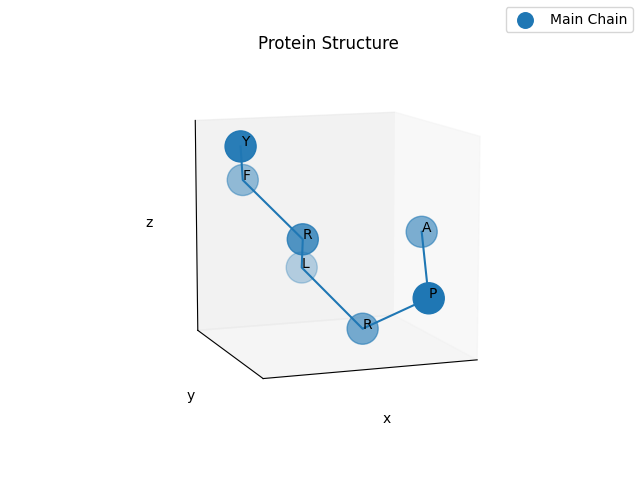

In [8]:
%matplotlib ipympl
fig = result.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)